In [1]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics For Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: Session Overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

**Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

Following steps we have already implemented and understood in the session 3:

In [3]:
# Load data
df = pd.read_csv('../03-classification/churn-data.csv')

# Clean column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Extract categorical column names from df
categorical_columns = df.select_dtypes('object').columns.tolist()

# Clean values in the categorical_columns
for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
# Convert column totalcharges to numeric
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

# Fill missing values of totalcharges with 0
df.totalcharges = df.totalcharges.fillna(0)

# Convert target variable churn from bool to binary integer
df.churn = (df.churn == 'yes').astype(int)

In [4]:
# Split 80% train and 20% test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split 60% train and 20% validation sets
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Create target variable for train/val/test
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# Delete target valriable churn from features
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
# Create list of numeric and categorical columns (exclude customerid)
# note: seniorcitizen column is categorical
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner',
               'dependents', 'phoneservice', 'multiplelines',
               'internetservice', 'onlinesecurity', 'onlinebackup',
               'deviceprotection', 'techsupport', 'streamingtv',
               'streamingmovies', 'contract', 'paperlessbilling',
               'paymentmethod']

In [6]:
# Instantiate DictVectorizer(sparse=False)
dv = DictVectorizer(sparse=False)

# Convert df_train to dictionary
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# Transform and fit train_dict using dv
X_train = dv.fit_transform(train_dict)

# Create model and fit the model to train
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Convert validation from dataframe to dictionary
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Transform data
X_val = dv.transform(val_dict)

# Make prediction
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate model accuracy
churn_decision = y_pred >= 0.5
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and Dummy Model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [8]:
# Calculate the accuracy again
(y_val == churn_decision).mean()

0.8034066713981547

We can see the model accuracy is 80% when the threshold is `0.5`. Basically, the accuracy is measured by calculating the `correct predictions` divided by `total number of predictions`. Let's manually apply the accuracy below:

In [9]:
correct_preds = (y_val == churn_decision).sum()
total_preds = len(churn_decision)

correct_preds / total_preds

0.8034066713981547

Indeed we get the same accuracy. We can also accuracy the accuracy using sklearn.

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, churn_decision)

0.8034066713981547

By default, logistic regression uses 0.5 threshold to optimize the results for accuracy. Let's see what happens when we calculate the accuracy on different thresholds, for that we'll create a dummy model for evaluation.

In [11]:
# Create an array of 21 different thresholds between 0 and 1 
thresholds = np.linspace(0, 1, 21)

# List to store accuracy
scores = []
for t in thresholds:
    churn_decision = y_pred >= t
    score = accuracy_score(y_val, churn_decision)
    scores.append(score)
    print(f'{t:.2f} - {score:.3f}')

0.00 - 0.274
0.05 - 0.509
0.10 - 0.591
0.15 - 0.666
0.20 - 0.710
0.25 - 0.739
0.30 - 0.760
0.35 - 0.772
0.40 - 0.785
0.45 - 0.793
0.50 - 0.803
0.55 - 0.801
0.60 - 0.795
0.65 - 0.786
0.70 - 0.765
0.75 - 0.744
0.80 - 0.735
0.85 - 0.726
0.90 - 0.726
0.95 - 0.726
1.00 - 0.726


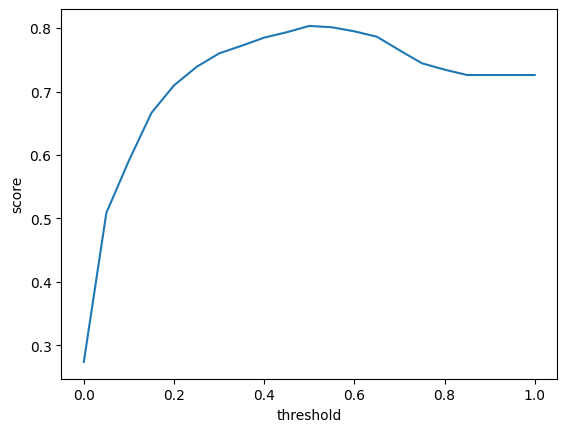

In [12]:
# Plot the thresholds and scores
plt.plot(thresholds, scores)
plt.xlabel('threshold')
plt.ylabel('score')
plt.show();

As we can see the best accuracy is at threshold 0.5. But what this graph actually tells us? To answer that, let's look at the distribution of the prdictions when the threshold is 1.0.

In [13]:
from collections import Counter

# Count customers distribution for churn and not churn on predictions
Counter(y_pred >= 1.0)

Counter({False: 1409})

Predictions at the threshold 1.0 tells us that no customer is going to churn (`1409 total number of customer`) but when we look at the actual values (y_val) the distribution is different.

In [14]:
# Count customers distribution for churn and not churn on validation
Counter(y_val)

Counter({0: 1023, 1: 386})

The actual values tell us that 1023 customers did not churn and 386 churned.

So, the dummy model predicts at threshold 1.0 no customer will churn and it gives us the accuracy of approximately 73% accuracy, which makes the difference of only 7% compare to the original model (80%). Therefore, accuracy metric can't exactly tells us how good is our model and that's because our data has imbalance classes with the ratio of 3:1. 

These results will be misleading, hence, we need other metrics for model evaluation.

## 4.3 Confusion Table

- Different types of errors and correct decisions
- Arranging them in a table

Confusion table tells us how many prediction our model has made correct and how many it has made incorrect. For binary classification classifier, there are possiblities that can happen in terms of predictions:

- Churn (Positive class)
    - Customer churned (TP)
    - Customer did not churn (FP)
- Not churn (Negative class)
    - Customer churned (TN)
    - Customer did not churn (FN)
    
Confusion table is helpful to analysis the quality of the model and how close it is making predictions to the acutal values. We can make the confusion table in numpy in the following way:

In [15]:
# Create arrays to represent actual class labels
actual_positive = y_val == 1
actual_negative = y_val == 0

In [16]:
# Create arrays to represent predicted class labels
t = 0.5 # threshold
predict_positive = y_pred >= t
predict_negative = y_pred < t

Now we have the actual and predicted class labels, we can combine them to derive tp, tn, fp, and fn:

In [17]:
# Calculate number of true positive class labels
tp = (predict_positive & actual_positive).sum()
# Calculate number of true negative class labels
tn = (predict_negative & actual_negative).sum()

# Calculate number of false positive class labels
fp = (predict_positive & actual_negative).sum()
# Calculate number of false negative class labels
fn = (predict_negative & actual_positive).sum()

In [18]:
# Create confusion matrix
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

We can get the ratio of these values by dividing confusion matrix with its sum.

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

As we have talked about it earlier the accuracy, it is the correct predictions (tn + tp) that our model made. The confusion matrix is telling us exactly that (`65% + 15% = 80%`), and that was indeed the model predictions. We can calculate the accuracy using the formula:

$$\frac{TN + TP}{TN + TP + FN + FP}$$

In [20]:
# Calculate accuracy
acc = (tn + tp) / (tn + tp + fn + fp)
acc.round(2)*100

80.0

## 4.4 Precision and Recall

If we consider the problem we have in hand, we can say that:
- **Precision**: Among all the customers classified by the model as potential churn, the fraction of that ended up to churned
- **Recall**: Among all the customers that ended up to churned, the fraction of that the model correctly classified

Precision is the fraction of TP divided by TP + FP, therefore it only consider positive labels: 

$$\frac{TP}{TP + FP}$$

Recall is the fraction of TP divided by TP + FN:

$$\frac{TP}{TP + FN}$$

Let's see how we can calculate them:

In [21]:
# Calculate precision
p = tp / (tp + fp)
p.round(2)

0.68

We get the precision of 68% and what that means it 22% of the customer who were not going to churn but got the promotion.

In [24]:
# Calculate recall
r = tp / (tp + fn)
r.round(2)

0.54

Recall is 54% which means our model failed to identify 46% of customer who are churning.

Precision and recall give us the complete picture of the model performance and that's why making assumption on the basis of accuracy can be misleading due to imbalance class distribution.

## 4.5 ROC Curves

### TPR and FRP

